<center><img src='./Figs/cs-logo.png' width=200></center>



<h6><center></center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center>TP3 : Detection de contours </center>
<hr style=" border:none; height:3px;">
</h1>


L'objectif de ce TP est double : d'une part comprendre le principe de la détection de contours en implémentant votre propre détecteur de Canny puis ensuite il s'agira de comparer les différents algorithmes présents dans OpenCV. Enfin, on s'intéressera à la détection de lignes dans des images de route.


## Exercice 1 : Votre propre détecteur de Canny

Il s'agira d'implémenter les étapes suivantes :
 + Lissage par un filtre gaussien.
 + Calcul des gradients.
 + Supression des non-maxima.
 + Seuillage.
 + Seuillage par hysterésis.

### Lissage par un filtre gaussien

Ouvrir une image et convoluer cette image par un filtre gaussien de taille de noyau 3 et avec $\sigma=1$. Vous pourrez pour cela utiliser la fonction **GaussianBlur** d'OpenCV : documentation [ici](https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html)


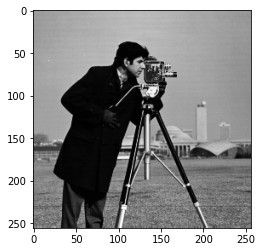

In [2]:
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('./Data/LAB3/cameraman.png',1)
img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap = 'gray')
plt.show()


Tester avec différentes tailles de noyau et différentes valeurs de $\sigma$. Afficher l'image originale et l'image filtrée

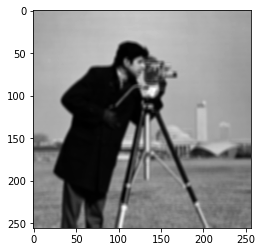

In [7]:
kernel_size = 5
sigma = 1.4

gaussian_blur = cv2.GaussianBlur(img_gray,(5,5),1.4,1.4,cv2.BORDER_DEFAULT)

plt.imshow(gaussian_blur, cmap = 'gray')
plt.show()

### Calcul des gradients

Vous avez ici deux possibilités :
+ Utiliser les fonctions d'Open CV et notamment le filtre de Sobel sur l'image d'origine.
+ Proposer vos propres filtres approximant les dérivées premières et les appliquer aux images précedemment lissées

Documentation [ici](https://docs.opencv.org/3.2.0/d5/d0f/tutorial_py_gradients.html)


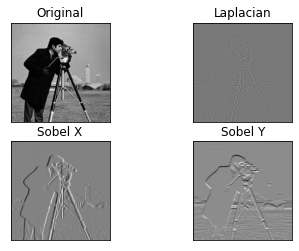

In [8]:
# avec le laplacian
laplacian = cv2.Laplacian(img_gray,cv2.CV_64F)

# avec sobel
sobelx = cv2.Sobel(img_gray,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img_gray,cv2.CV_64F,0,1,ksize=5)



plt.subplot(2,2,1),plt.imshow(img_gray,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

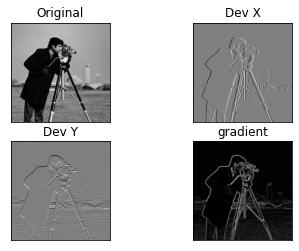

In [30]:
# Solution avec proposition de ses propres filtres



def conv(image, kernel):
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))

    # Padding
    pad_width0 = Hk // 2
    pad_width1 = Wk // 2
    pad_width = ((pad_width0,pad_width0),(pad_width1,pad_width1))
    padded = np.pad(image, pad_width, mode='edge')

    kernel = np.flip(np.flip(kernel, 0), 1)
    for i in range(Hi):
        for j in range(Wi):
            out[i, j] = np.sum(padded[i: i+Hk, j: j+Wk] * kernel)


    return out

def gaussian_kernel(size, sigma):
    
    kernel = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            kernel[i, j] = (1/(2*np.pi*sigma**2)) * np.exp(-((i - size//2)**2 + (j - size//2)**2) / float(2*sigma**2))


    return kernel

def partial_x(img):

    out = None

    kernel = 1./2 * np.array([[1, 0, -1]])
    out = conv(img, kernel)

    return out

def partial_y(img):

    out = None

    kernel = 1./2 * np.array([[1], [0], [-1]])
    out = conv(img, kernel)

    return out

def gradient(img):
    G = np.zeros(img.shape)
    theta = np.zeros(img.shape)

    Gx = partial_x(img)
    Gy = partial_y(img)
    G = np.sqrt(Gx ** 2 + Gy ** 2)
    theta = (np.rad2deg(np.arctan2(Gy, Gx)) + 180) % 360
    return G, theta
    

img = cv2.imread('./Data/LAB3/cameraman.png',1)
img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
dev_x = partial_x(img_gray)
dev_y = partial_y(img_gray)

gradient_img,theta=gradient(img_gray)


plt.subplot(2,2,1),plt.imshow(img_gray,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(dev_x,cmap = 'gray')
plt.title('Dev X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(dev_y,cmap = 'gray')
plt.title('Dev Y'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(gradient_img,cmap = 'gray')
plt.title('gradient'), plt.xticks([]), plt.yticks([])
plt.show()


###  Suppression des non-maxima

Le principe (par discretisation de la direction) est le suivant :
 + Arrondir la direction du gradient avec un voisinage de 8 (plus proche 45 degré)
 + Comparer la force du gradient du pixel courant avec celle qui se trouve dans la direction arrondie positive et négative du gradient.
 + Conserver le pixel si sa force est plus grande que ses deux voisins dans la direction du gradient.



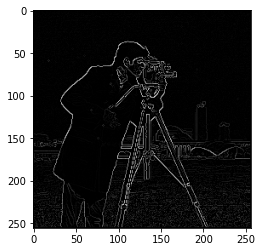

In [31]:
def non_maximum_suppression(G, theta):
    
    H, W = G.shape
    out = np.zeros((H, W))

    # Round the gradient direction to the nearest 45 degrees
    theta = np.floor((theta + 22.5) / 45) * 45

    for i in range(1, H-1):
        for j in range(1, W-1):
            alpha = np.deg2rad(theta[i, j])
            # note here the angle is measured clockwisely
            p1 = G[i-int(np.round(np.sin(alpha))), j-int(np.round(np.cos(alpha)))]
            p2 = G[i+int(np.round(np.sin(alpha))), j+int(np.round(np.cos(alpha)))]
            if not (G[i, j] >= p1 and G[i, j] >= p2):
                out[i, j] = 0
            else:
                out[i, j] = G[i, j]

    return out


max_gradient = non_maximum_suppression(gradient_img,theta)

plt.imshow(max_gradient, cmap = 'gray')
plt.show()


### Seuillage

Le detecteur de Canny utilise un double seuillage. Les pixels dont la force du contour est au dessus d'un premier seuil (seuil haut) sont conservés. Les pixels dont la force du contour est en dessous du deuxième seuil (seuil bas) sont supprimés. Les pixels restant sont considérés comme pixels faibles.  Mettre en oeuvre ce principe


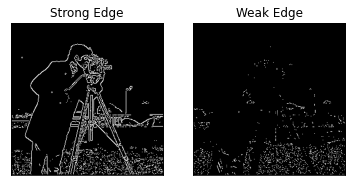

In [33]:
low_threshold = 15
high_threshold = 20


def double_thresholding(img, high, low):

    strong_edges = np.zeros(img.shape)
    weak_edges = np.zeros(img.shape)

    strong_edges = img > high
    weak_edges = (img < high) & (img > low)

    return strong_edges, weak_edges




threshold_image_strong,threshold_image_weak = double_thresholding(max_gradient,high_threshold,low_threshold)

plt.subplot(1,2,1),plt.imshow(threshold_image_strong,cmap = 'gray')
plt.title('Strong Edge'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(threshold_image_weak,cmap = 'gray')
plt.title('Weak Edge'), plt.xticks([]), plt.yticks([])

plt.show()

### Seuillage par hysterésis

Le principe consiste à ne garder que les pixels faibles qui sont dans le voisinage de pixels forts. Mettre en oeuvre ce principe avec une taille de voisinage pouvant se paramétrer.


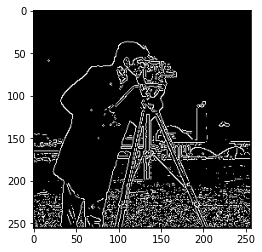

In [34]:
def get_neighbors(y, x, H, W):
    neighbors = []

    for i in (y-1, y, y+1):
        for j in (x-1, x, x+1):
            if i >= 0 and i < H and j >= 0 and j < W:
                if (i == y and j == x):
                    continue
                neighbors.append((i, j))

    return neighbors


def link_edges(strong_edges, weak_edges):
    H, W = strong_edges.shape
    indices = np.stack(np.nonzero(strong_edges)).T
    edges = np.zeros((H, W))

    edges = np.copy(strong_edges)
    for i in range(1, H-1):
        for j in range(1, W-1):
            neighbors = get_neighbors(j, i, H, W)
            if weak_edges[i, j] and np.any(edges[x, y] for x, y in neighbors):
                edges[i, j] = True

    return edges


edges = link_edges(threshold_image_strong,threshold_image_weak)


plt.imshow(edges, cmap = 'gray')
plt.show()

### Detecteur de Canny 

Tester votre détecteur de Canny ainsi créé sur plusieurs images. Comparer le avec celui implémenté dans OpenCV : [ici](https://docs.opencv.org/3.3.1/da/d22/tutorial_py_canny.html).

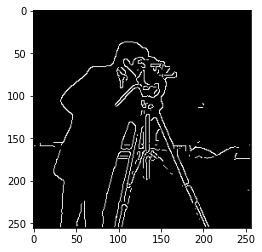

In [27]:
def canny(img, kernel_size=5, sigma=1.4, high=20, low=15):
    kernel = gaussian_kernel(kernel_size, sigma)
    smoothed = conv(img, kernel)
    G, theta = gradient(smoothed)
    nms = non_maximum_suppression(G, theta)
    strong_edges, weak_edges = double_thresholding(nms, high, low)
    edge = link_edges(strong_edges, weak_edges)

    return edge


my_canny_edge=canny(img_gray)

plt.imshow(my_canny_edge, cmap = 'gray')
plt.show()

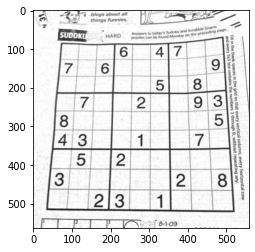

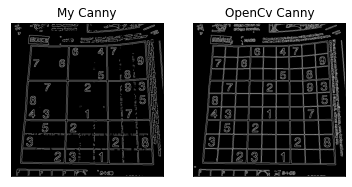

In [41]:
img = cv2.imread('./Data/LAB3/sudoku.png',1)
img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap = 'gray')
plt.show()


my_canny_edge=canny(img_gray)

opencv_canny_edge = cv2.Canny(img,100,200,5)

plt.subplot(1,2,1),plt.imshow(my_canny_edge,cmap = 'gray')
plt.title('My Canny'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(opencv_canny_edge ,cmap = 'gray')
plt.title('OpenCv Canny'), plt.xticks([]), plt.yticks([])

plt.show()


## Exercice 2 : Comparaison d'approches de detection de contours

L'objectif de cet exercice est de comparer différents algorithmes de détection de contours.
Plusieurs algorithmes sont présents pour la détection de contours dans OpenCV : *Sobel*, *Scharr*, *Laplacian* et *Canny*. La documentation utile est disponible [ici](http://docs.opencv.org/3.2.0/da/d22/tutorial_py_canny.html) et [ici](http://docs.opencv.org/3.2.0/d5/d0f/tutorial_py_gradients.html).

Vous allez faire une comparaison de 3 détecteurs de contours (Sobel, Laplace, Canny) avec 10 images différentes disponibles dans le répertoire Data. Ces images proviennent de la [base d'images de Berkeley](http://www.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/dataset/images.html) qui contient la vérité terrain (segmentation manuelle des contours par des humains). Vous pouvez augmenter le nombre d'images du jeu de données de test en récupérant d'autres images et leur vérité terrain en parcourant le jeu de données en ligne.

Ecrire un programme permettant d'apppliquer les différents détecteurs de contour sur les images de votre base de test/


In [ ]:
# TO COMPLETE

Cette étape consiste en la comparaison d'une image de contours avec la référence tracée à la main en utilisant 5 grandeurs :
+ **contours-detectes** = nombre de pixels contours dans l'image calculée.
+ **contours-reference** = nombre de pixels contours dans l'image de référence.
+ **contours-correc** = nombre de pixels contours correctement détectés dans l'image calculée selon l'image référence. 
Pour cette grandeur, il faudrait tenir compte d'un décalage possible entre les images. On négligera ce décalage ici.
+ **faux-positifs** = nombre de pixels détectés comme contours mais qui ne le sont pas dans l'image de référence.
+ **faux-negatifs** = nombre de pixels non détectés comme contours.

Ecrire le code permettant de calculer ces grandeurs étant données une image de contours et sa vérité terrain.


In [ ]:
# TO COMPLETE

 En déduire les trois mesures suivantes pour évaluer les détecteurs :
+  **P**=**contours-correc}** / (**contours-correc**+ **faux-positifs**+**faux-negatifs**)
+  **TFP*** = **faux-positifs** / (**contours-correc**+ **faux-positifs** +**faux-negatifs**)
+ **TFN** = **faux-negatifs** / (**contours-correc**+ **faux-positifs** +**faux-negatifs**)

Ecrire le code permettant de calculer ces mesures et calculer les sur la base de test. Discuter des résultats.



In [ ]:
# TO COMPLETE

## Exercice 3 : Détection de lignes
L'objectif de cet exercice est de tester l'approche de détection de lignes droites dans des images à l'aide du détecteur de contours et de la transformée de Hough. 
Le principe sera le suivant :
+ Détection des contours avec le meilleur détecteur à votre disposition (c.f. exercice 2).
+ Extraire les regions d'intérêts dans des images (dans les images à votre disposition les droites recherches sont dans la moitié basse de l'image et il est donc possible de définir un masque.
+ Appliquer la transformée de Hough pour la détection de droites.


Charger l'image **road.jpg** (repertoire Data/LAB3) ci dessous et appliquer un détecteur de contours.
![road.jpg](./Data/LAB3/road.jpg)

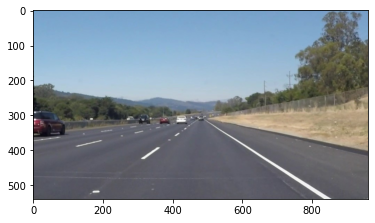

In [68]:
img = cv2.imread('./Data/LAB3/road.jpg',1)
img_BGR= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_BGR)
plt.show()


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Restreindre la detection des contours et des droites à la moitié basse de l'image en définissant un masque et donc une region d'intérêt.

In [69]:
def region_of_interest(img,vertices): 
    mask = np.zeros_like(img)        
    match_mask_color=  255  
    cv2.fillPoly(mask,vertices,match_mask_color)
    masked_image=cv2.bitwise_and(img,mask) 
    return masked_image

Appliquer la detection de contours sur cette région d'intérêt. Visualiser l'image résultat

In [70]:
height=img.shape[0]
width=img.shape[1]
region_of_interest_coor=[(0,height),(0,400),(width/2,height/3),(width,height)]
print(region_of_interest_coor)
canny_image = cv2.Canny(gray,100,200)
print(canny_image.shape)

cropped=region_of_interest(canny_image,np.array([region_of_interest_coor],np.int64))



[(0, 540), (0, 400), (480.0, 180.0), (960, 540)]
(540, 960)


Détecter les droites à l'aide de la fonction **cv2.HoughLines** d'openCV. Une documentation est disponible [ici](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html)

In [71]:
lines = cv2.HoughLinesP(cropped,rho=2,theta=np.pi/120,threshold=120,lines=np.array([]),minLineLength=20,maxLineGap=35)

Tester votre chaîne algorithmique sur d'autres images.

In [72]:
def draw_the_lines(img,lines): 
    imge=np.copy(img)     
    blank_image=np.zeros((imge.shape[0],imge.shape[1],3),dtype=np.uint8)
    for line in lines:  
        for x1,y1,x2,y2 in line:
            cv2.line(blank_image,(x1,y1),(x2,y2),(0,255,0),thickness=3)
            imge = cv2.addWeighted(imge,0.8,blank_image,1,0.0) 
    return imge

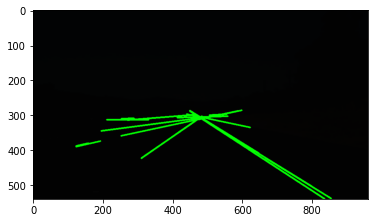

In [73]:
image_with_lines = draw_the_lines(img_BGR,lines) 

plt.imshow(image_with_lines)
plt.show()